# Imports

In [1]:
import pandas as pd
import numpy as np
import utils.read_data as read
import utils.features as features
from utils.handlers.constants import UNK

from catboost import CatBoostRanker, Pool
from sklearn.model_selection import GroupKFold, train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import shap

sns.set()

# Utils

In [2]:
SEED = 42

# Reading data

In [3]:
members = read.members("data/members.csv")

In [4]:
songs = read.songs("data/songs.csv")
song_extra_info = read.extra_info("data/song_extra_info.csv")

songs = songs.merge(song_extra_info, on="song_id", how="left")

In [5]:
train = read.train("data/train.csv")

# Generate features from data, e.g., raw age $\to$ somewhat of categorical desc. of user this is child, teenager etc.

In [6]:
members = features.member(members)
songs = features.song(songs)

# Final data

In [7]:
data = train.merge(members, on="msno", how="left").merge(songs, on="song_id", how="left").astype({"msno": "category", "song_id": "category"})

data.source_screen_name = data.source_screen_name.cat.add_categories(UNK).fillna(UNK)
data.source_system_tab = data.source_system_tab.cat.add_categories(UNK).fillna(UNK)
data.source_type = data.source_type.cat.add_categories(UNK).fillna(UNK)

data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,composer,lyricist,language,name,artist_count,composer_count,lyricist_count,genre_count,isrc_year,isrc_country
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,<UNK>,<UNK>,7,...,Dan Smith| Mark Crew,<UNK>,52.0,Good Grief,1.0,2.0,0.0,1.0,16,GB
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,<UNK>,<UNK>,52.0,Lords of Cardboard,1.0,0.0,0.0,1.0,99,US
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,N. Jones、W. Adams、J. Lordan、D. Ingle,<UNK>,52.0,Hip Hop Is Dead(Album Version (Edited)),1.0,1.0,0.0,1.0,6,US
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,Kwadwo Donkoh,<UNK>,-1.0,Disco Africa,1.0,1.0,0.0,1.0,10,GB
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,<UNK>,<UNK>,7,...,Brett Young| Kelly Archer| Justin Ebach,<UNK>,52.0,Sleep Without You,1.0,3.0,0.0,1.0,16,QM


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 29 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   msno                     category
 1   song_id                  category
 2   source_system_tab        category
 3   source_screen_name       category
 4   source_type              category
 5   target                   int32   
 6   city                     category
 7   bd                       category
 8   gender                   category
 9   registered_via           category
 10  registration_init_year   category
 11  registration_init_month  category
 12  registration_init_day    category
 13  expiration_year          category
 14  expiration_month         category
 15  expiration_day           category
 16  song_length              float64 
 17  genre_ids                category
 18  artist_name              category
 19  composer                 category
 20  lyricist                

# Are there any NAN values left?

In [9]:
na_mask = data.isna().any(1)
print(na_mask.sum())

1607


not terrible, I guess, we will remove these as it is negligible in comparison with whole remaining data (~7 millions)

In [10]:
data = data[~na_mask]

here we have some problems: firstly, catboost on CPU kinda sucks. Secondly, on GPU it cannot handle more than 1024 items...

In [11]:
data = data.groupby("msno").head(1023).reset_index(drop=True)
data.target.value_counts()

1    3563752
0    3450391
Name: target, dtype: int64

kinda balanced I guess

In [12]:
data.sort_values("msno", kind="stable", inplace=True)

# Task 1. GBDT (via CatBoost cos we have lotta categorical features)

In [13]:
cfg = {
    "loss_function": "YetiRank", 
    "iterations": 150, 
    "custom_metric": ["NDCG", "QueryAUC:type=Ranking"], 
    "random_seed": SEED, 
    "metric_period": 10,
    "task_type": "GPU",
    "train_dir": "YetiRank/" 
}

In [14]:
def pool(data):
    X = data.drop(columns=["target", "song_id", "msno"], axis=1)
    y = data.target.to_numpy()
    q = data.msno.cat.codes.to_numpy()
    
    categorical_features = X.select_dtypes(["category"]).columns.to_numpy()
    return Pool(data=X, label=y, group_id=q, cat_features=categorical_features, has_header=True)

In [15]:
X = data.drop(columns=["target", "msno", "song_id"], axis=1)
y = data.target.to_numpy()
q = data.msno.cat.codes.to_numpy()

categorical_features = X.select_dtypes(["category"]).columns.to_numpy()

In [16]:
scores = []
for train_idx, val_idx in GroupKFold(n_splits=5).split(X, y, q):
    X_train = X.iloc[train_idx]
    y_train = y[train_idx]
    
    X_val = X.iloc[val_idx]
    y_val = y[val_idx]
    
    q_train = q[train_idx]
    q_val = q[val_idx]
    
    pool_train = Pool(data=X_train, label=y_train, group_id=q_train, cat_features=categorical_features, has_header=True)
    pool_val = Pool(data=X_val, label=y_val, group_id=q_val, cat_features=categorical_features, has_header=True)
    
    model = CatBoostRanker(**cfg)
    model.fit(pool_train, eval_set=pool_val)
    
    scores.append(model.get_evals_result())

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5044113	best: 0.5044113 (0)	total: 621ms	remaining: 1m 32s
10:	test: 0.7719295	best: 0.7719295 (10)	total: 3.97s	remaining: 50.2s
20:	test: 0.7830203	best: 0.7830203 (20)	total: 7.38s	remaining: 45.4s
30:	test: 0.7842786	best: 0.7842786 (30)	total: 10.9s	remaining: 41.9s
40:	test: 0.7853580	best: 0.7853580 (40)	total: 14.6s	remaining: 38.7s
50:	test: 0.7856133	best: 0.7856133 (50)	total: 17.9s	remaining: 34.8s
60:	test: 0.7861255	best: 0.7861255 (60)	total: 21.2s	remaining: 31s
70:	test: 0.7868895	best: 0.7868895 (70)	total: 24.5s	remaining: 27.3s
80:	test: 0.7874682	best: 0.7874682 (80)	total: 27.9s	remaining: 23.7s
90:	test: 0.7868167	best: 0.7874682 (80)	total: 31.2s	remaining: 20.3s
100:	test: 0.7870235	best: 0.7874682 (80)	total: 34.7s	remaining: 16.8s
110:	test: 0.7869543	best: 0.7874682 (80)	total: 37.9s	remaining: 13.3s
120:	test: 0.7873501	best: 0.7874682 (80)	total: 41.2s	remaining: 9.88s
130:	test: 0.7874563	best: 0.7874682 (80)	total: 44.5s	remaining: 6.45s
140:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5162266	best: 0.5162266 (0)	total: 594ms	remaining: 1m 28s
10:	test: 0.7697068	best: 0.7697068 (10)	total: 3.87s	remaining: 48.9s
20:	test: 0.7776295	best: 0.7776295 (20)	total: 7.17s	remaining: 44s
30:	test: 0.7791388	best: 0.7791388 (30)	total: 10.4s	remaining: 40.1s
40:	test: 0.7799961	best: 0.7799961 (40)	total: 13.8s	remaining: 36.8s
50:	test: 0.7810351	best: 0.7810351 (50)	total: 17.2s	remaining: 33.3s
60:	test: 0.7818134	best: 0.7818134 (60)	total: 20.6s	remaining: 30s
70:	test: 0.7823966	best: 0.7823966 (70)	total: 23.9s	remaining: 26.6s
80:	test: 0.7823193	best: 0.7823966 (70)	total: 27.2s	remaining: 23.2s
90:	test: 0.7823899	best: 0.7823966 (70)	total: 30.6s	remaining: 19.8s
100:	test: 0.7827258	best: 0.7827258 (100)	total: 33.9s	remaining: 16.5s
110:	test: 0.7831037	best: 0.7831037 (110)	total: 37.2s	remaining: 13.1s
120:	test: 0.7833428	best: 0.7833428 (120)	total: 40.6s	remaining: 9.74s
130:	test: 0.7833825	best: 0.7833825 (130)	total: 44s	remaining: 6.39s
140:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4889416	best: 0.4889416 (0)	total: 575ms	remaining: 1m 25s
10:	test: 0.7696983	best: 0.7696983 (10)	total: 3.83s	remaining: 48.4s
20:	test: 0.7757025	best: 0.7757025 (20)	total: 7.15s	remaining: 43.9s
30:	test: 0.7763098	best: 0.7763098 (30)	total: 10.4s	remaining: 40.1s
40:	test: 0.7766979	best: 0.7766979 (40)	total: 13.7s	remaining: 36.5s
50:	test: 0.7769524	best: 0.7769524 (50)	total: 17.1s	remaining: 33.2s
60:	test: 0.7773970	best: 0.7773970 (60)	total: 20.4s	remaining: 29.8s
70:	test: 0.7783843	best: 0.7783843 (70)	total: 23.7s	remaining: 26.4s
80:	test: 0.7784911	best: 0.7784911 (80)	total: 27s	remaining: 23s
90:	test: 0.7787037	best: 0.7787037 (90)	total: 30.4s	remaining: 19.7s
100:	test: 0.7790987	best: 0.7790987 (100)	total: 33.7s	remaining: 16.4s
110:	test: 0.7791563	best: 0.7791563 (110)	total: 37s	remaining: 13s
120:	test: 0.7793226	best: 0.7793226 (120)	total: 40.3s	remaining: 9.66s
130:	test: 0.7794050	best: 0.7794050 (130)	total: 43.6s	remaining: 6.32s
140:	te

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5055952	best: 0.5055952 (0)	total: 608ms	remaining: 1m 30s
10:	test: 0.7758791	best: 0.7758791 (10)	total: 3.83s	remaining: 48.4s
20:	test: 0.7818439	best: 0.7818439 (20)	total: 7.12s	remaining: 43.7s
30:	test: 0.7812099	best: 0.7818439 (20)	total: 10.4s	remaining: 40.1s
40:	test: 0.7819493	best: 0.7819493 (40)	total: 13.8s	remaining: 36.6s
50:	test: 0.7824947	best: 0.7824947 (50)	total: 17.1s	remaining: 33.2s
60:	test: 0.7822271	best: 0.7824947 (50)	total: 20.4s	remaining: 29.8s
70:	test: 0.7824542	best: 0.7824947 (50)	total: 23.8s	remaining: 26.4s
80:	test: 0.7828812	best: 0.7828812 (80)	total: 27.2s	remaining: 23.1s
90:	test: 0.7829187	best: 0.7829187 (90)	total: 30.6s	remaining: 19.8s
100:	test: 0.7828195	best: 0.7829187 (90)	total: 34s	remaining: 16.5s
110:	test: 0.7827996	best: 0.7829187 (90)	total: 37.4s	remaining: 13.1s
120:	test: 0.7832040	best: 0.7832040 (120)	total: 40.9s	remaining: 9.8s
130:	test: 0.7838168	best: 0.7838168 (130)	total: 44.3s	remaining: 6.43s
140:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4974295	best: 0.4974295 (0)	total: 609ms	remaining: 1m 30s
10:	test: 0.7667629	best: 0.7667629 (10)	total: 4.18s	remaining: 52.8s
20:	test: 0.7756241	best: 0.7756241 (20)	total: 7.51s	remaining: 46.1s
30:	test: 0.7768954	best: 0.7768954 (30)	total: 10.8s	remaining: 41.5s
40:	test: 0.7773610	best: 0.7773610 (40)	total: 14.1s	remaining: 37.5s
50:	test: 0.7779060	best: 0.7779060 (50)	total: 17.4s	remaining: 33.7s
60:	test: 0.7786720	best: 0.7786720 (60)	total: 20.7s	remaining: 30.2s
70:	test: 0.7788033	best: 0.7788033 (70)	total: 24s	remaining: 26.7s
80:	test: 0.7791428	best: 0.7791428 (80)	total: 27.5s	remaining: 23.4s
90:	test: 0.7809887	best: 0.7809887 (90)	total: 30.8s	remaining: 20s
100:	test: 0.7818162	best: 0.7818162 (100)	total: 34.3s	remaining: 16.6s
110:	test: 0.7818304	best: 0.7818304 (110)	total: 37.6s	remaining: 13.2s
120:	test: 0.7815145	best: 0.7818304 (110)	total: 41s	remaining: 9.83s
130:	test: 0.7816216	best: 0.7818304 (110)	total: 44.3s	remaining: 6.43s
140:	

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 0, 'Iteration')

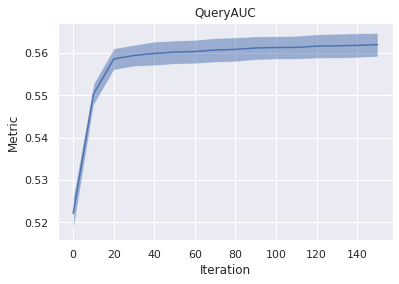

In [17]:
quac = np.vstack([x["validation"]["QueryAUC:type=Ranking"] for x in scores])

mean = quac.mean(0)
std = quac.std(0)

x = np.arange(cfg["iterations"] // cfg["metric_period"] + 1) * cfg["metric_period"]

ax = sns.lineplot(x, mean)
ax.fill_between(x, mean - std, mean + std, alpha = 0.5)

ax.set_title("QueryAUC")
ax.set_ylabel("Metric")
ax.set_xlabel("Iteration")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 0, 'Iteration')

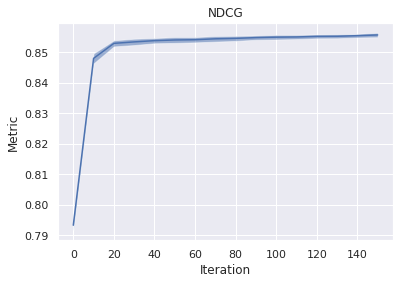

In [18]:
ndcg = np.vstack([x["validation"]["NDCG:type=Base"] for x in scores])

mean = ndcg.mean(0)
std = ndcg.std(0)

x = np.arange(cfg["iterations"] // cfg["metric_period"] + 1) * cfg["metric_period"]

ax = sns.lineplot(x, mean)
ax.fill_between(x, mean - std, mean + std, alpha = 0.5)

ax.set_title("NDCG")
ax.set_ylabel("Metric")
ax.set_xlabel("Iteration")

In [19]:
idxs_train, idxs_test = train_test_split(np.random.permutation(len(data)), test_size=1000)
idxs_train = sorted(idxs_train)  # do not forget to sort it as catboost expected query to be grouped
idxs_test = sorted(idxs_test)

In [20]:
model = CatBoostRanker(**cfg)

pool_train = pool(data.iloc[idxs_train])
pool_test = pool(data.iloc[idxs_test])

model.fit(pool_train)

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 454ms	remaining: 1m 7s
10:	total: 4.12s	remaining: 52s
20:	total: 7.87s	remaining: 48.3s
30:	total: 11.6s	remaining: 44.6s
40:	total: 15.4s	remaining: 41s
50:	total: 19.3s	remaining: 37.5s
60:	total: 23.2s	remaining: 33.9s
70:	total: 27s	remaining: 30s
80:	total: 30.9s	remaining: 26.3s
90:	total: 34.7s	remaining: 22.5s
100:	total: 38.5s	remaining: 18.7s
110:	total: 42.3s	remaining: 14.9s
120:	total: 46s	remaining: 11s
130:	total: 49.9s	remaining: 7.23s
140:	total: 53.5s	remaining: 3.42s
149:	total: 56.8s	remaining: 0us


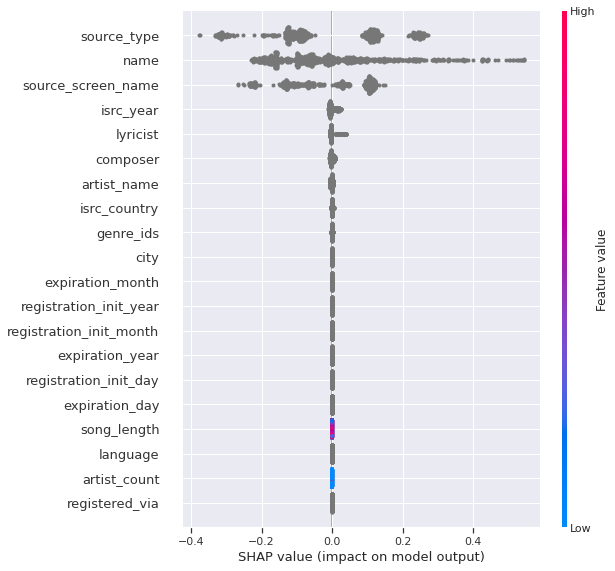

In [21]:
X_test = data.iloc[idxs_test].drop(columns=["target", "song_id", "msno"], axis=1)
se = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_vals = se.shap_values(X_test)
shap.summary_plot(shap_vals, X_test)

Most important features: where an user played a song for the first time, name of a song, and at which layout of the app he did that.

Seems kinda reasonable...

In [22]:
shap.initjs()
shap.force_plot(se.expected_value, shap_vals, X_test)